# Network analysis
First, import relevant libraries:

In [340]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from pylab import *

import igraph as ig # Need to install this in your virtual environment

import psycopg2
# from re import sub

from scipy.spatial.distance import squareform, pdist # Use for getting weights for layout

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# import os
# import sys
# sys.path.append('/home/mmalik/optourism-repo' + "/pipeline")
# from firenzecard_analyzer import *

In [3]:
# TODO: connect with dbutils
conn_str = ""
conn = psycopg2.connect(conn_str)
cursor = conn.cursor()

Then, load the data (takes a few moments):

In [4]:
nodes = pd.read_sql('select * from optourism.firenze_card_locations', con=conn)
nodes.head()

museum_name  longitude   latitude  museum_id  \
0         Basilica di Santa Croce  11.262598  43.768754          1   
1            Basilica San Lorenzo  11.254430  43.774932          2   
2      Battistero di San Giovanni  11.254966  43.773131          3   
3  Biblioteca Medicea Laurenziana  11.253924  43.774799          4   
4              Cappella Brancacci  11.243859  43.768334          5   

        short_name string  
0      Santa Croce      C  
1      San Lorenzo      2  
2  Opera del Duomo      D  
3      Laurenziana      l  
4        Brancacci      b

In [5]:
df = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
df['museum_id'].replace(to_replace=38,value=39,inplace=True)
df['short_name'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['short_name'])))
df['string'] = df['museum_id'].replace(dict(zip(nodes['museum_id'],nodes['string'])))
df['date'] = pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df['hour'] = pd.to_datetime(df['date']) + pd.to_timedelta(pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.hour, unit='h')
df.head()

user_id               museum_name          entry_time  adults_first_use  \
0  2070971  Palazzo Pitti Cumulativo 2016-08-08 11:25:00                 0   
1  2070972  Palazzo Pitti Cumulativo 2016-08-08 11:25:00                 0   
2  2071063  Palazzo Pitti Cumulativo 2016-08-08 11:40:00                 0   
3  2070258  Palazzo Pitti Cumulativo 2016-08-08 11:43:00                 0   
4  2069915  Palazzo Pitti Cumulativo 2016-08-08 11:43:00                 0   

   adults_reuse  total_adults  minors  museum_id     short_name string  \
0             1             1       0         39  Palazzo Pitti      P   
1             1             1       0         39  Palazzo Pitti      P   
2             1             1       0         39  Palazzo Pitti      P   
3             1             1       0         39  Palazzo Pitti      P   
4             1             1       0         39  Palazzo Pitti      P   

         date                hour  
0  2016-08-08 2016-08-08 11:00:00  
1  2016-08-08 2016-08-08 11:00:00  
2  2016-08-08 2016-08-08 11:00:00  
3  2016-08-08 2016-08-08 11:00:00  
4  2016-08-08 2016-08-08 11:00:00

In [6]:
# Helper function for making summary tables/distributions
def frequency(dataframe,columnname):
    out = dataframe[columnname].value_counts().to_frame()
    out.columns = ['frequency']
    out.index.name = columnname
    out.reset_index(inplace=True)
    out.sort_values(columnname,inplace=True)
    out['cumulative'] = out['frequency'].cumsum()/out['frequency'].sum()
    out['ccdf'] = 1 - out['cumulative']
    return out

I propose distinguishing _paths_ from _flows_. A path is an itinerary, and the flow is the number of people who take the flow. E.g., a family or a tour group produces one path, but adds mulitple people to the overall flow. 

We now build a transition graph, a directed graph where an edge represents a person going from one museum to another *within the same day*. 

We also produce the *transition matrix,* a row-normalized n-by-n matrix of the frequency of transition from the row node to the column node. If you take a vector of the current volumes in each location, and multiply that my the transition matrix, you get a prediction for the number of people on each node at the next time. This prediction can be refined with corrections for daily/weekly patterns and such. 

# Other exploratory/summary plots

In [7]:
timeunitname = 'hour' # 'day'
timeunitcode = 'h' # 'D'
df1 = df.groupby(['short_name',timeunitname]).sum()
df1['total_people'] = df1['total_adults']+df1['minors']
df1.drop(['museum_id','user_id','adults_first_use','adults_reuse','total_adults','minors'], axis=1, inplace=True)
df1.head()

total_people
short_name hour                             
Accademia  2016-06-01 08:00:00            17
           2016-06-01 09:00:00            37
           2016-06-01 10:00:00            51
           2016-06-01 11:00:00            33
           2016-06-01 12:00:00            36

In [8]:
df1 = df1.reindex(pd.MultiIndex.from_product([df['short_name'].unique(),pd.date_range('2016-06-01','2016-10-01',freq=timeunitcode)]), fill_value=0)
df1.reset_index(inplace=True)
df1.columns = ['short_name','hour','total_people']
df1.head()

short_name                hour  total_people
0  Palazzo Pitti 2016-06-01 00:00:00             0
1  Palazzo Pitti 2016-06-01 01:00:00             0
2  Palazzo Pitti 2016-06-01 02:00:00             0
3  Palazzo Pitti 2016-06-01 03:00:00             0
4  Palazzo Pitti 2016-06-01 04:00:00             0

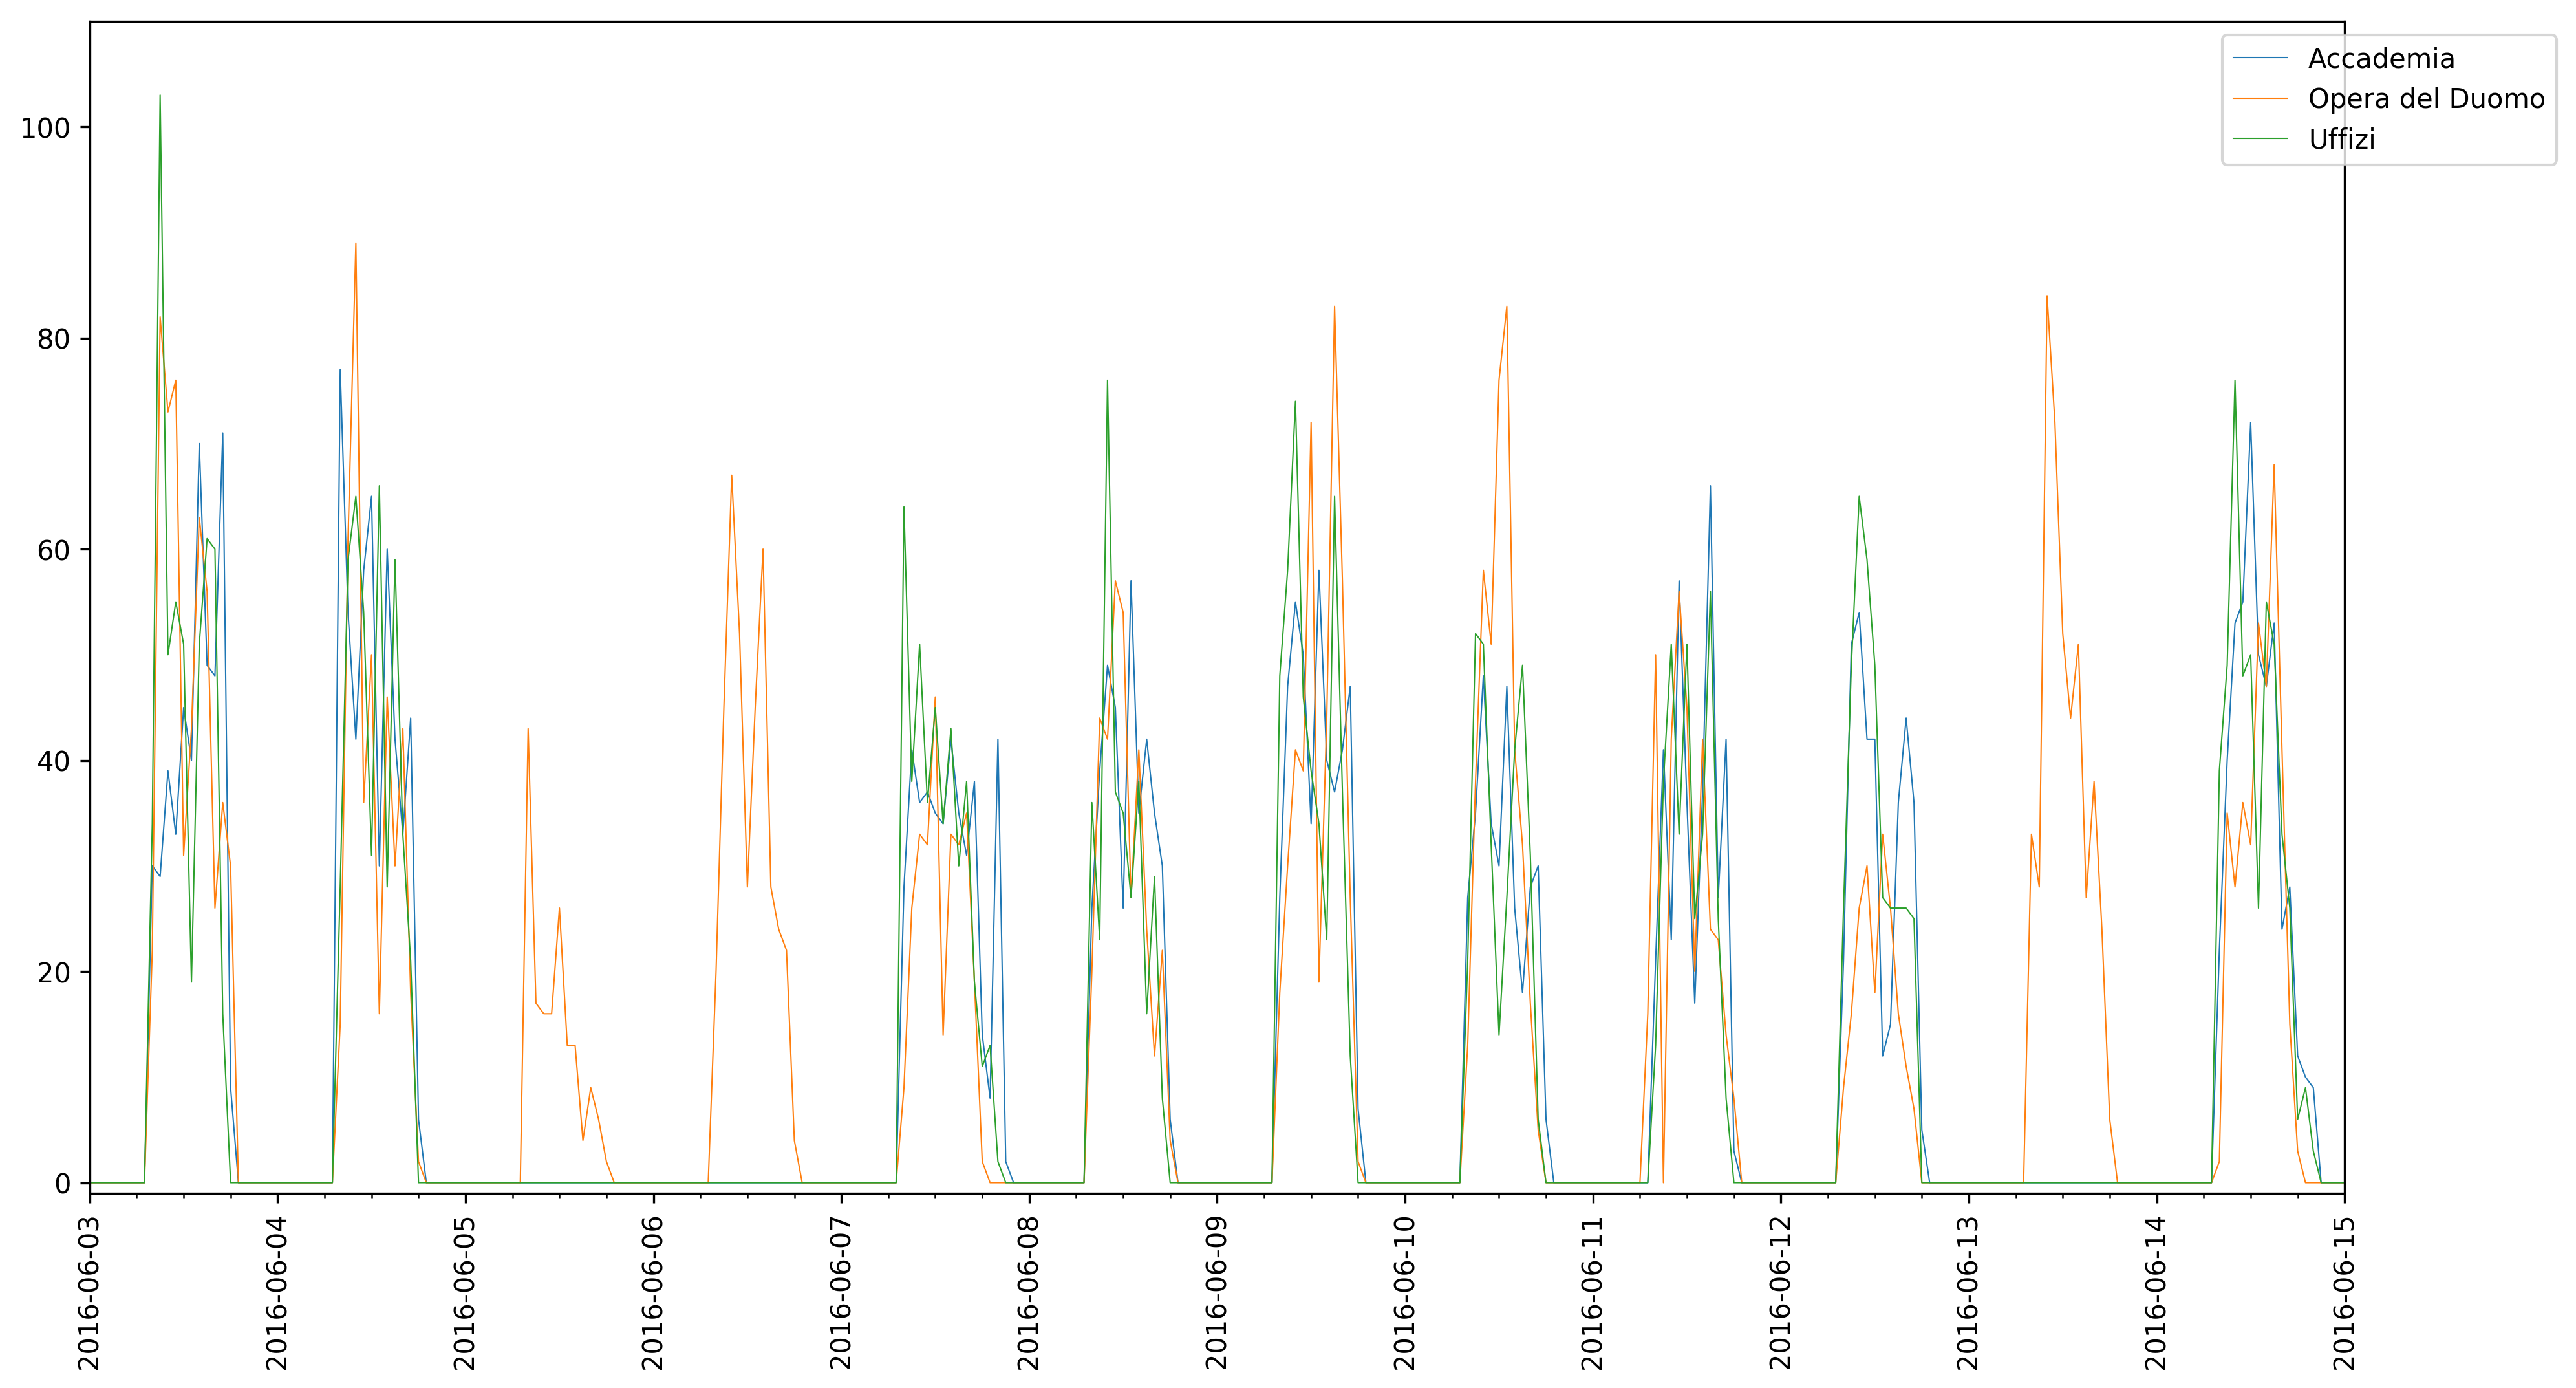

In [9]:
# multiline plot with group by
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,8), dpi=300)
for key, grp in df1.groupby(['short_name']):
    if key in ['Accademia','Uffizi','Opera del Duomo']:
        ax.plot(grp['hour'], grp['total_people'], linewidth=.5, label=str(key))
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
ax.set_xlim(['2016-06-03','2016-06-15'])
ax.set_ylim([-1,110])
# plt.xticks(pd.date_range('2016-06-01','2016-06-15',freq='D'))
ticks = pd.date_range('2016-06-03','2016-06-15',freq='D').date
plt.xticks(ticks, ticks, rotation='vertical')
ax.set_xticks(pd.date_range('2016-06-03','2016-06-15',freq='6h'), minor=True, )
# fig.autofmt_xdate()
# ax.fmt_xdata = mdates.DateFormatter('%m-%d')
plt.show()

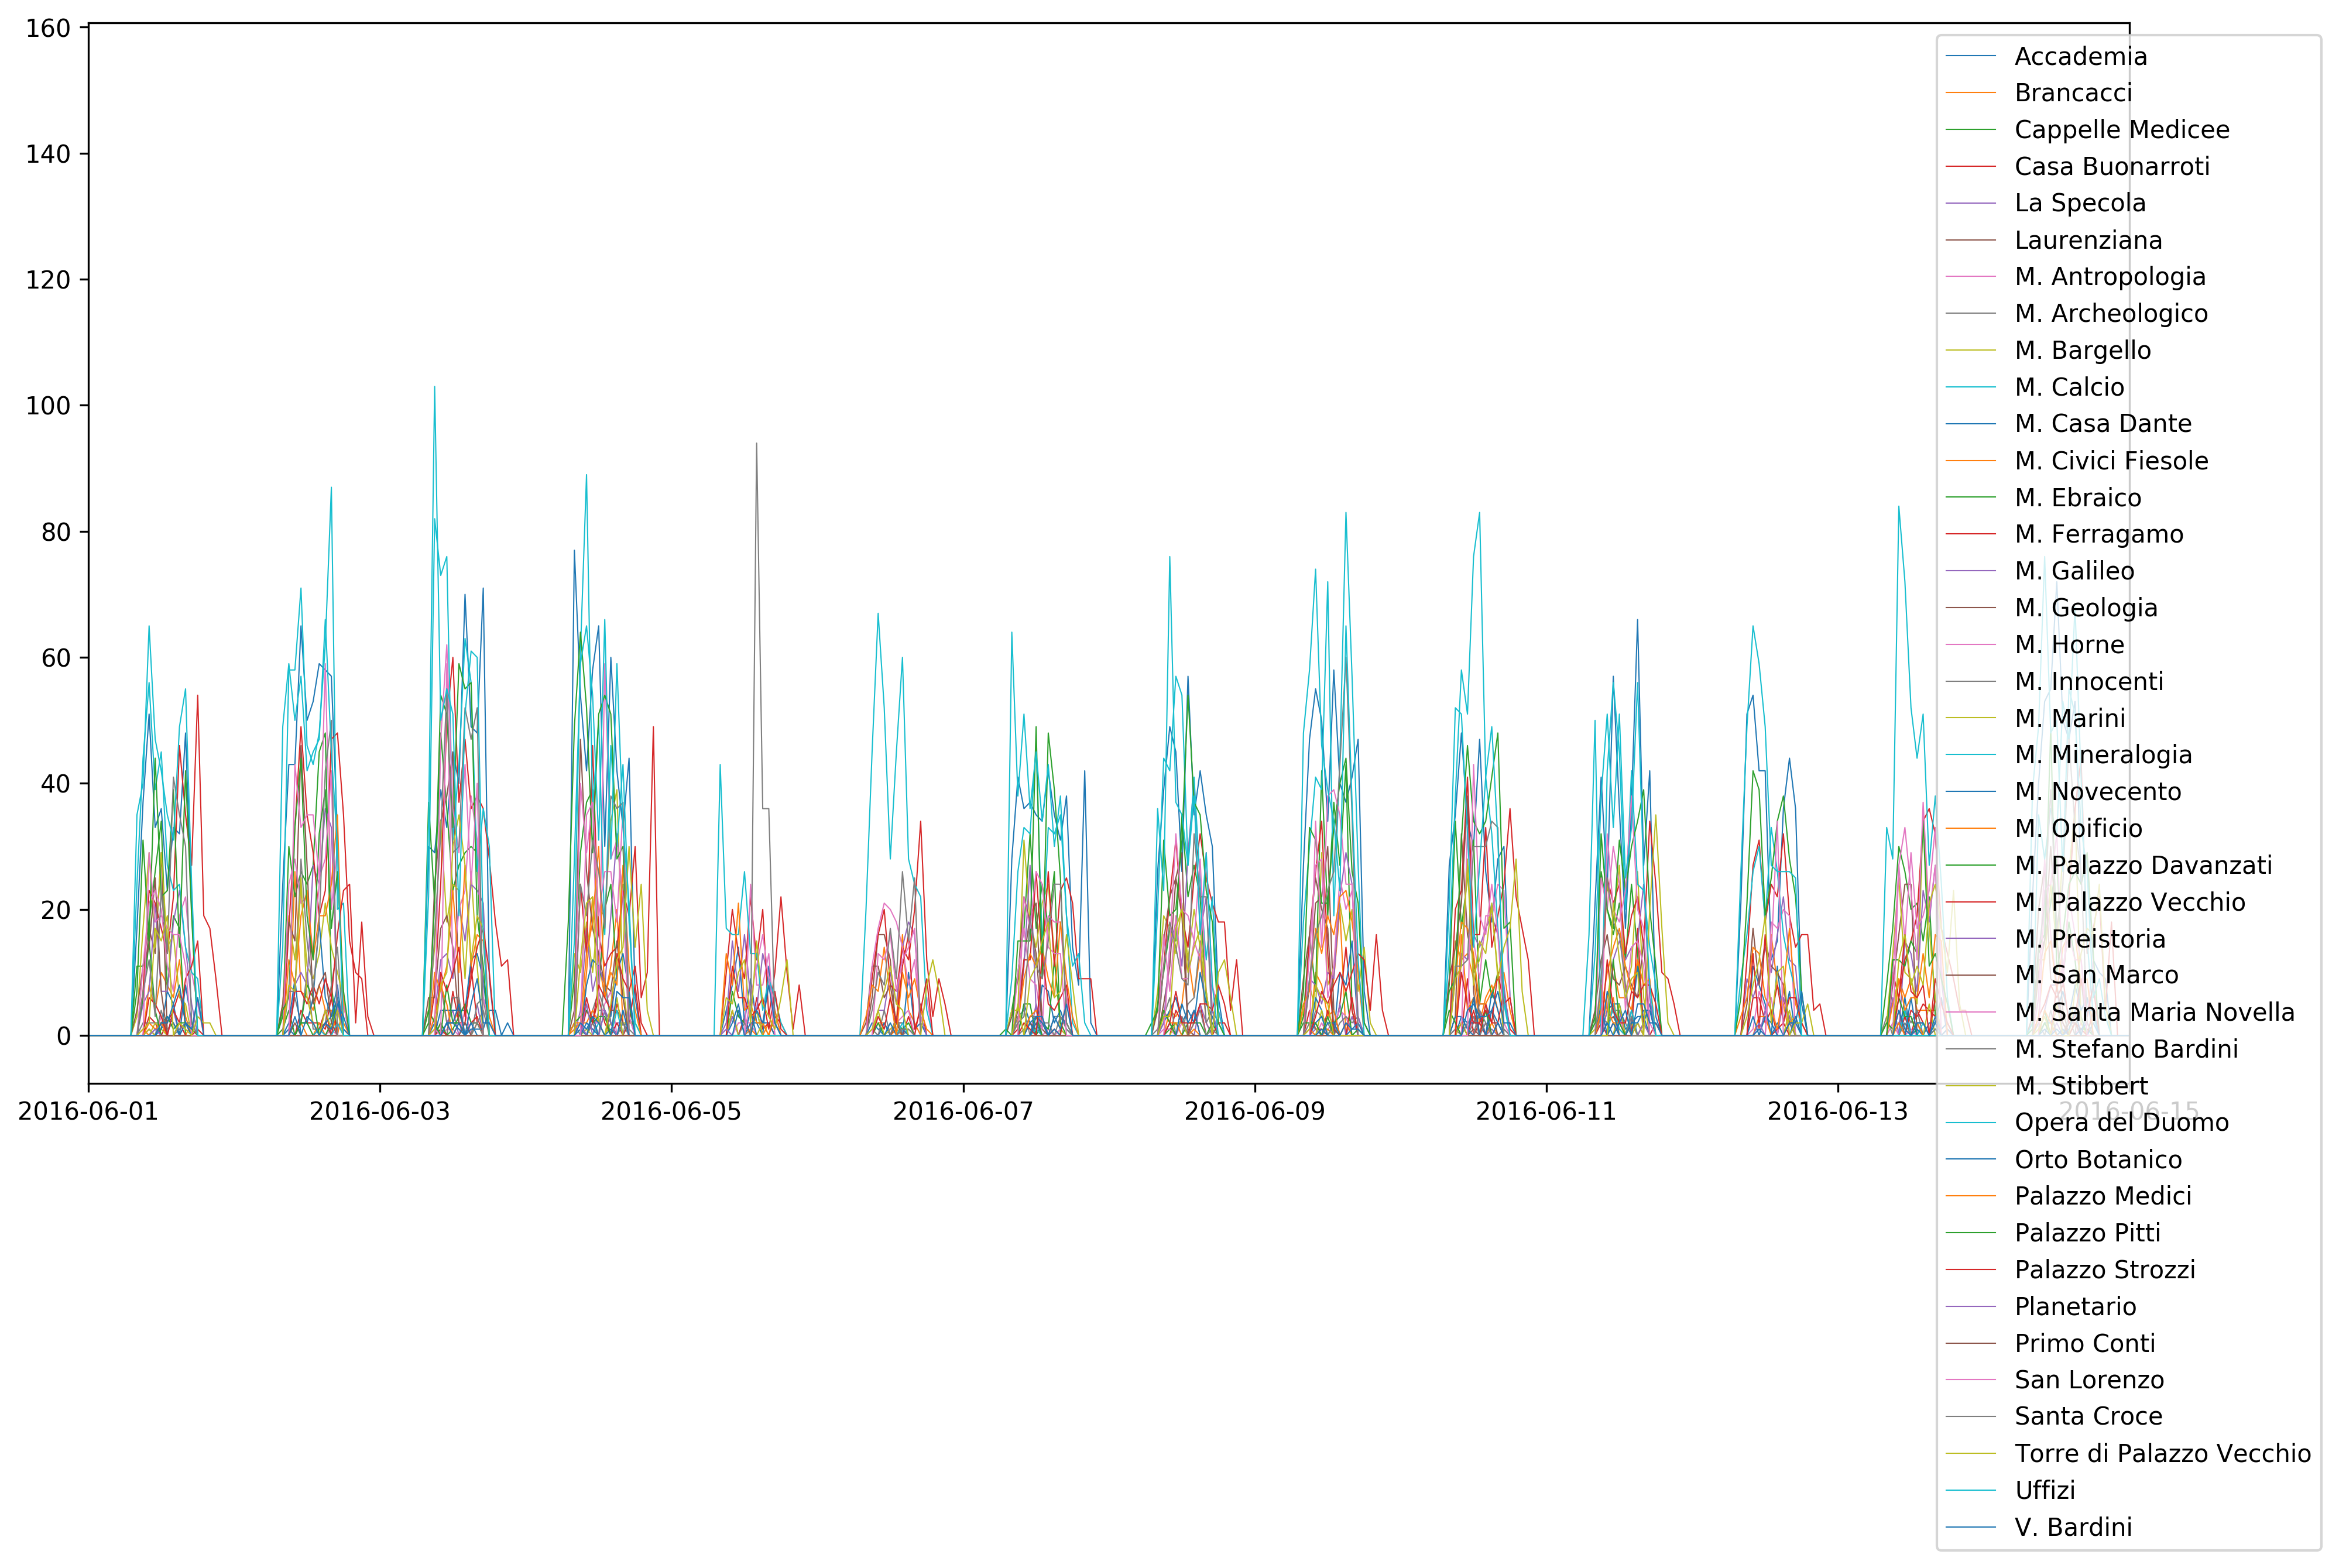

In [10]:
# multiline plot with group by
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,8), dpi=300)
for key, grp in df1.groupby(['short_name']):
    ax.plot(grp['hour'], grp['total_people'], linewidth=.5, label=str(key))
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
ax.set_xlim(['2016-06-01','2016-06-15'])
plt.show()

In [11]:
df2 = df.groupby('museum_name').sum()[['total_adults','minors']]
df2['total_people'] = df2['total_adults'] + df2['minors']
df2.sort_values('total_people',inplace=True,ascending=False)
df2.head()

total_adults  minors  \
museum_name                                                                
Battistero di San Giovanni                                 44047    5842   
Galleria degli Uffizi                                      40622    3717   
Galleria dell'Accademia di Firenze                         39364    3053   
Museo di Palazzo Vecchio                                   29403    3354   
Palazzo Pitti 2 Ð Giardino di Boboli, Museo deg...         29142    3155   

                                                    total_people  
museum_name                                                       
Battistero di San Giovanni                                 49889  
Galleria degli Uffizi                                      44339  
Galleria dell'Accademia di Firenze                         42417  
Museo di Palazzo Vecchio                                   32757  
Palazzo Pitti 2 Ð Giardino di Boboli, Museo deg...         32297

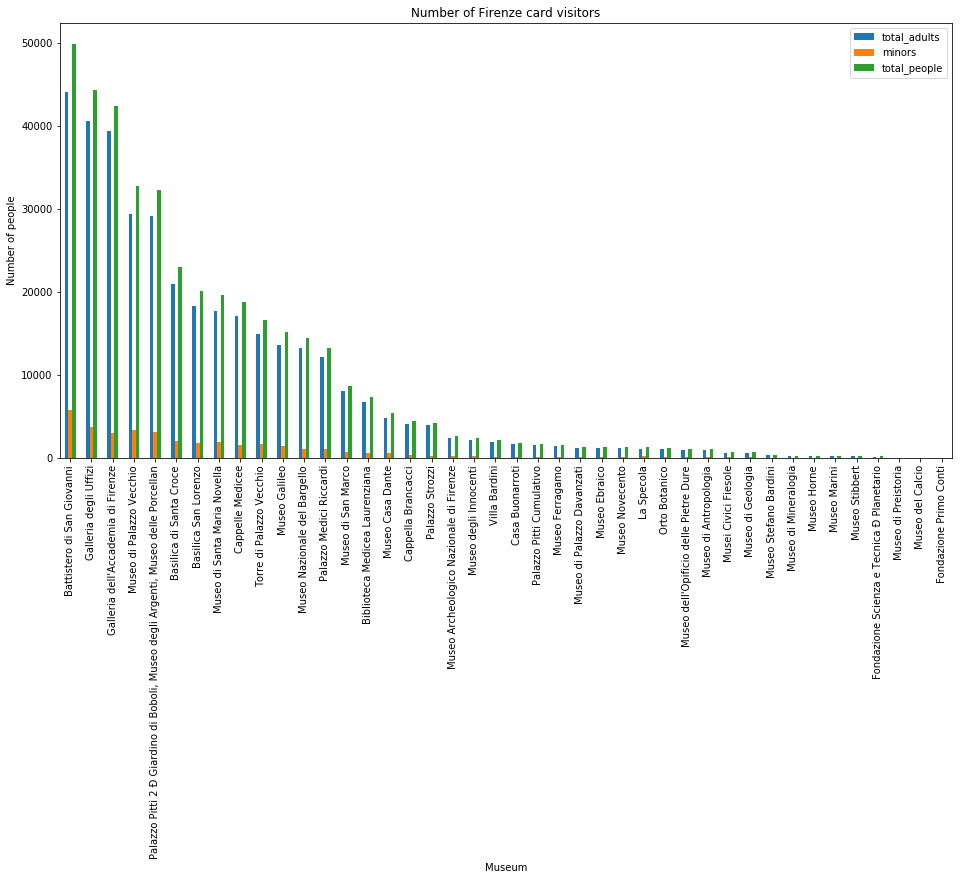

In [12]:
df2.plot.bar(figsize=(16,8))
plt.title('Number of Firenze card visitors')
plt.xlabel('Museum')
plt.ylabel('Number of people')
# plt.yscale('log')
plt.show()

# Transition/Origin-Destination (OD) matrix 

Now, we make a graph of the transitions for museums. To do this, we make an edgelist out of the above. 

Specifically, we want an edgelist where the first column is the origin site, the second column is the destination site, the third column is the number of people (total adults plus rows for minors), and the fourth column is the time stamp of the entry to the _destination_ museum. 

But, there's a twist. We want to track when people arrive at the first museum of their day. We can do this by adding a dummy "source" node that everybody starts each day from. We can then query this dummy node to see not only which museum people activate their Firenze card from, but also the museum where they start their other days. For visualizations, we can drop it (or not visualize it). 

We could also have people return to this source node at the end of each day (or make a separate "target" node for this purpose), but there would be no timestamp for that arrival so it would complicate the data with missing values. However, we might still want to do this, analogously to find the last museum people tend to visit in a day. 

I will create this source node by the following: first, create an indicator for if the previous record is the same day and the same Firenze card. If it is, we make a link from the museum of the previous row and the museum of that row. 

If the previous row is either a different day and/or a different user_id, make a link between the dummy "source" node and that row's museum. 

I do this below in a different order: I initialize a "from" column with all source, then overwrite with the museum of the previous row if the conditions are met. 

In [13]:
# df3 = df.sort_values(['user_id','entry_time'],ascending=False,inplace=False)
# df3.reset_index(inplace=True)
# df3.drop(['index','museum_id'], axis=1, inplace=True)
# df3.head()
# df3.groupby(['user_id','date','museum_name','entry_time']).sum().head(10) # Even though this grouping's multiindex looks nicer

In [14]:
df4 = df.groupby(['user_id','entry_time','date','hour','museum_name','short_name','string']).sum() # Need to group in this order to be correct further down
df4['total_people'] = df4['total_adults'] + df4['minors']
df4.head()

adults_first_use  \
user_id entry_time          date       hour                museum_name                        short_name      string                     
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                      1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                      0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                      0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                      0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                      0   

                                                                                                                      adults_reuse  \
user_id entry_time          date       hour                museum_name                        short_name      string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                  0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                  1   

                                                                                                                      total_adults  \
user_id entry_time          date       hour                museum_name                        short_name      string                 
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U                  1   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3                  1   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A                  1   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D                  1   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G                  1   

                                                                                                                      minors  \
user_id entry_time          date       hour                museum_name                        short_name      string           
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U            0   
        2016-06-22 14:26:00 2016-06-22 2016-06-22 14:00:00 Museo Casa Dante                   M. Casa Dante   3            0   
        2016-06-22 15:49:00 2016-06-22 2016-06-22 15:00:00 Galleria dell'Accademia di Firenze Accademia       A            0   
        2016-06-23 09:43:00 2016-06-23 2016-06-23 09:00:00 Battistero di San Giovanni         Opera del Duomo D            0   
        2016-06-23 11:14:00 2016-06-23 2016-06-23 11:00:00 Museo Galileo                      M. Galileo      G            0   

                                                                                                                      museum_id  \
user_id entry_time          date       hour                museum_name                        short_name      string              
1459702 2016-06-22 10:04:00 2016-06-22 2016-06-22 10:00:00 Galleria degli Uffizi              Uffizi          U   

In [15]:
df4.reset_index(inplace=True)
df4.drop(['adults_first_use','adults_reuse','total_adults','minors','museum_id'], axis = 1, inplace=True)
df4.head(10)

user_id          entry_time        date                hour  \
0  1459702 2016-06-22 10:04:00  2016-06-22 2016-06-22 10:00:00   
1  1459702 2016-06-22 14:26:00  2016-06-22 2016-06-22 14:00:00   
2  1459702 2016-06-22 15:49:00  2016-06-22 2016-06-22 15:00:00   
3  1459702 2016-06-23 09:43:00  2016-06-23 2016-06-23 09:00:00   
4  1459702 2016-06-23 11:14:00  2016-06-23 2016-06-23 11:00:00   
5  1459702 2016-06-23 12:57:00  2016-06-23 2016-06-23 12:00:00   
6  1459702 2016-06-23 13:41:00  2016-06-23 2016-06-23 13:00:00   
7  1459702 2016-06-23 15:05:00  2016-06-23 2016-06-23 15:00:00   
8  1473903 2016-06-19 11:24:00  2016-06-19 2016-06-19 11:00:00   
9  1473903 2016-06-20 12:05:00  2016-06-20 2016-06-20 12:00:00   

                          museum_name          short_name string  total_people  
0               Galleria degli Uffizi              Uffizi      U             1  
1                    Museo Casa Dante       M. Casa Dante      3             1  
2  Galleria dell'Accademia di Firenze           Accademia      A             1  
3          Battistero di San Giovanni     Opera del Duomo      D             1  
4                       Museo Galileo          M. Galileo      G             1  
5            Museo di Palazzo Vecchio  M. Palazzo Vecchio      V             1  
6        Museo Nazionale del Bargello         M. Bargello      B             1  
7             Basilica di Santa Croce         Santa Croce      C             1  
8               Galleria degli Uffizi              Uffizi      U             1  
9          Battistero di San Giovanni     Opera del Duomo      D             1

In [16]:
df4['from'] = 'source' # Initialize 'from' column with 'source'
df4['to'] = df4['short_name'] # Copy 'to' column with row's museum_name
df4.head(10)

user_id          entry_time        date                hour  \
0  1459702 2016-06-22 10:04:00  2016-06-22 2016-06-22 10:00:00   
1  1459702 2016-06-22 14:26:00  2016-06-22 2016-06-22 14:00:00   
2  1459702 2016-06-22 15:49:00  2016-06-22 2016-06-22 15:00:00   
3  1459702 2016-06-23 09:43:00  2016-06-23 2016-06-23 09:00:00   
4  1459702 2016-06-23 11:14:00  2016-06-23 2016-06-23 11:00:00   
5  1459702 2016-06-23 12:57:00  2016-06-23 2016-06-23 12:00:00   
6  1459702 2016-06-23 13:41:00  2016-06-23 2016-06-23 13:00:00   
7  1459702 2016-06-23 15:05:00  2016-06-23 2016-06-23 15:00:00   
8  1473903 2016-06-19 11:24:00  2016-06-19 2016-06-19 11:00:00   
9  1473903 2016-06-20 12:05:00  2016-06-20 2016-06-20 12:00:00   

                          museum_name          short_name string  \
0               Galleria degli Uffizi              Uffizi      U   
1                    Museo Casa Dante       M. Casa Dante      3   
2  Galleria dell'Accademia di Firenze           Accademia      A   
3          Battistero di San Giovanni     Opera del Duomo      D   
4                       Museo Galileo          M. Galileo      G   
5            Museo di Palazzo Vecchio  M. Palazzo Vecchio      V   
6        Museo Nazionale del Bargello         M. Bargello      B   
7             Basilica di Santa Croce         Santa Croce      C   
8               Galleria degli Uffizi              Uffizi      U   
9          Battistero di San Giovanni     Opera del Duomo      D   

   total_people    from                  to  
0             1  source              Uffizi  
1             1  source       M. Casa Dante  
2             1  source           Accademia  
3             1  source     Opera del Duomo  
4             1  source          M. Galileo  
5             1  source  M. Palazzo Vecchio  
6             1  source         M. Bargello  
7             1  source         Santa Croce  
8             1  source              Uffizi  
9             1  source     Opera del Duomo

In [17]:
make_link = (df4['user_id'].shift(1)==df4['user_id'])&(df4['date'].shift(1)==df4['date']) # Row indexes at which to overwrite 'source'
df4['from'][make_link] = df4['short_name'].shift(1)[make_link]
df4.head(10)

user_id          entry_time        date                hour  \
0  1459702 2016-06-22 10:04:00  2016-06-22 2016-06-22 10:00:00   
1  1459702 2016-06-22 14:26:00  2016-06-22 2016-06-22 14:00:00   
2  1459702 2016-06-22 15:49:00  2016-06-22 2016-06-22 15:00:00   
3  1459702 2016-06-23 09:43:00  2016-06-23 2016-06-23 09:00:00   
4  1459702 2016-06-23 11:14:00  2016-06-23 2016-06-23 11:00:00   
5  1459702 2016-06-23 12:57:00  2016-06-23 2016-06-23 12:00:00   
6  1459702 2016-06-23 13:41:00  2016-06-23 2016-06-23 13:00:00   
7  1459702 2016-06-23 15:05:00  2016-06-23 2016-06-23 15:00:00   
8  1473903 2016-06-19 11:24:00  2016-06-19 2016-06-19 11:00:00   
9  1473903 2016-06-20 12:05:00  2016-06-20 2016-06-20 12:00:00   

                          museum_name          short_name string  \
0               Galleria degli Uffizi              Uffizi      U   
1                    Museo Casa Dante       M. Casa Dante      3   
2  Galleria dell'Accademia di Firenze           Accademia      A   
3          Battistero di San Giovanni     Opera del Duomo      D   
4                       Museo Galileo          M. Galileo      G   
5            Museo di Palazzo Vecchio  M. Palazzo Vecchio      V   
6        Museo Nazionale del Bargello         M. Bargello      B   
7             Basilica di Santa Croce         Santa Croce      C   
8               Galleria degli Uffizi              Uffizi      U   
9          Battistero di San Giovanni     Opera del Duomo      D   

   total_people                from                  to  
0             1              source              Uffizi  
1             1              Uffizi       M. Casa Dante  
2             1       M. Casa Dante           Accademia  
3             1              source     Opera del Duomo  
4             1     Opera del Duomo          M. Galileo  
5             1          M. Galileo  M. Palazzo Vecchio  
6             1  M. Palazzo Vecchio         M. Bargello  
7             1         M. Bargello         Santa Croce  
8             1              source              Uffizi  
9             1              source     Opera del Duomo

In [18]:
# Create the actual edgelist for the transition matrix (of a first-order Markov chain)
df5 = df4.groupby(['from','to'])['total_people'].sum().to_frame()
df5.columns = ['weight']
df5.reset_index(inplace=True)
df5.head(10)

from                to  weight
0  Accademia         Accademia       2
1  Accademia         Brancacci      77
2  Accademia  Cappelle Medicee    1277
3  Accademia   Casa Buonarroti      49
4  Accademia        La Specola      30
5  Accademia       Laurenziana     301
6  Accademia   M. Antropologia      51
7  Accademia   M. Archeologico     826
8  Accademia       M. Bargello    1022
9  Accademia         M. Calcio       2

In [19]:
# Make exportable dynamic edgelist
# df4[['from','to','total_people','entry_time']].sort_values('entry_time').to_csv('dynamic_edgelist.csv')
out = df4[['from','to','total_people','entry_time']].sort_values('total_people',ascending=False)
out.columns = ['source','target','people','datetime']
out.to_csv('dynamic_edgelist.csv',index=False)

In [20]:
# # Make actual graph object to export as gml
# out = df4[['from','to','total_people','entry_time']].sort_values('total_people',ascending=False)
# out.columns = ['source','target','people','datetime']

# g = ig.Graph.TupleList(df4.itertuples(index=False), directed=True, weights=True)
# ig.summary(g)

In [21]:
# g.es.attributes()

In [22]:
# Create and check the graph
g = ig.Graph.TupleList(df5.itertuples(index=False), directed=True, weights=True)
ig.summary(g)

IGRAPH DNW- 42 1240 -- 
+ attr: name (v), weight (e)


In [23]:
# g.vs['name']

In [24]:
# Save the weighted indegree calculated with the source node before dropping it
indeg = g.strength(mode='in',weights='weight')[0:-1] # This drops the "source" node, which is last

In [25]:
# Delete the dummy 'source' node
g.delete_vertices([v.index for v in g.vs if v['name']==u'source'])
g.simplify(loops=False, combine_edges=sum)
ig.summary(g)

IGRAPH DNW- 41 1199 -- 
+ attr: name (v), weight (e)


In [26]:
# Put in graph attributes to help with plotting
g.vs['label'] = g.vs["name"] 
# g.vs[sub("'","",i.decode('unicode_escape').encode('ascii','ignore')) for i in g2.vs["name"]] # Is getting messed up!

In [27]:
# g2.vs['label']

In [28]:
# Get coordinates, requires this lengthy query
latlon = pd.DataFrame({'short_name':g.vs['label']}).merge(nodes[['short_name','longitude','latitude']],left_index=True,how='left',on='short_name')

In [29]:
# Latitude is flipped, need to multiply by -1 to get correct orientation
g.vs['x'] = (latlon['longitude']).values.tolist()
g.vs['y'] = (-1*latlon['latitude']).values.tolist()

In [30]:
# # Make distances matrix for a layout based on geography but with enough spacing to not overplot and cause ZeroDivisionError
# # Want to convert the distances into attraction, do with "gravity" of 1/(d^2)
# dist = pd.DataFrame(squareform(pdist(nodes.iloc[:, 1:3])), columns=nodes['short_name'], index=nodes['short_name'])
# grav = dist.pow(-2)
# np.fill_diagonal(grav.values, 0)
# grav.head()

In [31]:
# A = grav.values
# g2 = ig.Graph.Adjacency((A > 0).tolist())
# g2.es['weight'] = A[A.nonzero()]
# g2.vs['label'] = grav.index

In [32]:
# layout = g2.layout("fr",weights='weight')
# ig.plot(g2,layout=layout)

In [33]:
# layout = g.layout_fruchterman_reingold(seed=nodes[['longitude','latitude']].values.tolist(),maxiter=5,maxdelta=.01)
# ig.plot(g,layout=layout)

In [34]:
g.delete_edges(g.es.find(_between=(g.vs(name_eq='Torre di Palazzo Vecchio'), g.vs(name_eq='M. Palazzo Vecchio'))))
g.delete_edges(g.es.find(_between=(g.vs(name_eq='M. Palazzo Vecchio'),g.vs(name_eq='Torre di Palazzo Vecchio'))))
ig.summary(g)

IGRAPH DNW- 41 1197 -- 
+ attr: label (v), name (v), x (v), y (v), weight (e)


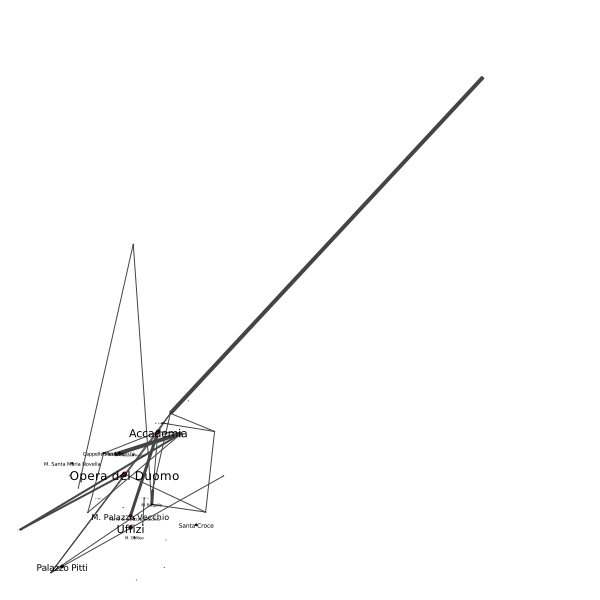

In [35]:
visual_style = {}
visual_style['vertex_size'] = [.000075*i for i in indeg] # .00075 is from hand-tuning
visual_style['vertex_label_size'] = [.00025*i for i in indeg]
visual_style['edge_width'] = [np.floor(.001*i) for i in g.es["weight"]] # Scale weights. .001*i chosen by hand. Try also .05*np.sqrt(i)
# visual_style['edge_curved'] = True
# visual_style["autocurve"] = True
ig.plot(g.as_undirected(), **visual_style) # Positions, for reference

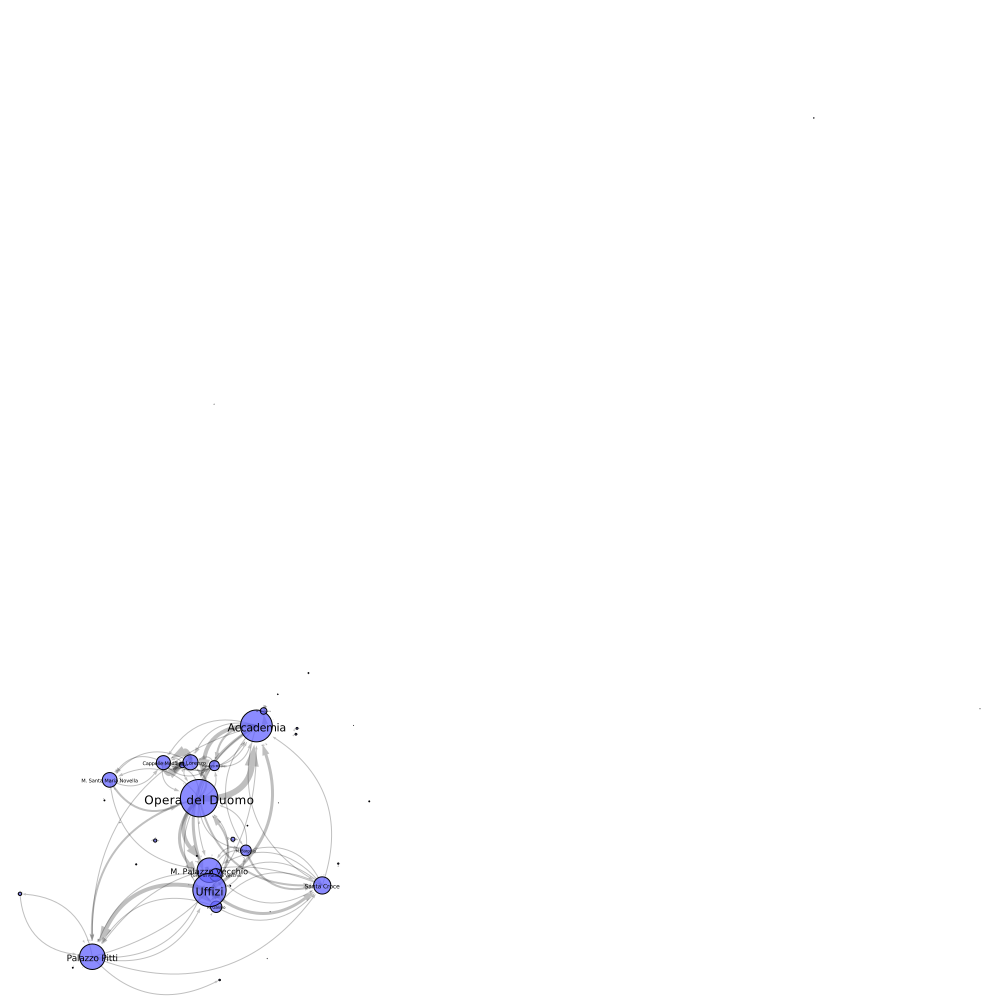

In [42]:
# layout = g.layout_fruchterman_reingold(seed=nodes[['longitude','latitude']].values.tolist(),maxiter=4)
# layout = g.layout_drl(seed=nodes[['longitude','latitude']].values.tolist(), fixed=[True]*len(g.vs))
# layout = g.layout_drl(seed=nodes[['longitude','latitude']].values.tolist(), fixed=[True]*len(g.vs), weights='weight')
# layout = g.layout_graphopt(seed=nodes[['longitude','latitude']].values.tolist(), niter=1, node_mass=1)
visual_style = {}
visual_style['edge_width'] = [np.floor(.001*i) for i in g.es["weight"]] # Scale weights. .001*i chosen by hand. Try also .05*np.sqrt(i)
visual_style['edge_arrow_size'] = [.00025*i for i in g.es["weight"]] # .00025*i chosen by hand. Try also .01*np.sqrt(i)
visual_style['vertex_size'] = [.00075*i for i in indeg] # .00075 is from hand-tuning
visual_style['vertex_label_size'] = [.00025*i for i in indeg]
visual_style['vertex_color'] = "rgba(100, 100, 255, .75)"
visual_style['edge_color'] = "rgba(0, 0, 0, .25)"
# visual_style['edge_curved'] = True
visual_style["autocurve"] = True
ig.plot(g, 'graph.svg', bbox = (1000,1000), **visual_style)

In [99]:
# print(g2.get_adjacency()) # This was another check; before it was very nearly upper triangular. Now it looks much better. Copy into a text editor and resize to see the whole matrix.

In [43]:
transition_matrix = pd.DataFrame(g.get_adjacency(attribute='weight').data, columns=g.vs['name'], index=g.vs['name'])

In [325]:
# transition_matrix.loc[transition_matrix.idxmax(axis=0).values].idxmax(axis=1).index

In [326]:
# pd.Index(pd.Series(transition_matrix.loc[transition_matrix.idxmax(axis=0).values].max(axis=1).sort_values(ascending=False).index.unique().tolist() + transition_matrix.max(axis=1).sort_values(ascending=False).to_frame().index.tolist()).unique())

In [327]:
# temp = pd.DataFrame({'museum':transition_matrix.idxmax(axis=0).values,'values':transition_matrix.max(axis=0).values}).groupby('museum').max().sort_values('values',ascending=False)
# temp.reset_index(inplace=True)
# temp2 = transition_matrix.max(axis=0).to_frame().reset_index()
# temp2.columns = ['museum','values']
# temp = temp.append(temp2)
# order = temp.groupby('museum').max().sort_values('values',ascending=False).index

In [328]:
# order

In [329]:
# order = pd.Index([u'Opera del Duomo', 
#                   u'Accademia', 
#                   u'Uffizi', 
#                   u'Palazzo Pitti', 
#                   u'M. Palazzo Vecchio', 
#                   u'M. Galileo', 
#                   u'Santa Croce', 
#                   u'Cappelle Medicee', 
#                   u'San Lorenzo', 
#                   u'Laurenziana', 
#                   u'Palazzo Medici', 
#                   u'M. Bargello', 
#                   u'M. Santa Maria Novella', 
#                   u'M. San Marco', 
#                   u'Torre di Palazzo Vecchio', 
#                   u'M. Casa Dante', 
#                   u'Brancacci', 
#                   u'V. Bardini', 
#                   u'M. Archeologico', 
#                   u'Casa Buonarroti', 
#                   u'M. Innocenti', 
#                   u'M. Novecento', 
#                   u'La Specola', 
#                   u'Palazzo Strozzi', 
#                   u'M. Opificio', 
#                   u'Orto Botanico', 
#                   u'M. Geologia', 
#                   u'M. Mineralogia', 
#                   u'M. Ebraico', 
#                   u'M. Antropologia', 
#                   u'M. Ferragamo', 
#                   u'M. Palazzo Davanzati', 
#                   u'M. Horne', 
#                   u'M. Civici Fiesole', 
#                   u'M. Marini', 
#                   u'M. Stefano Bardini', 
#                   u'Planetario', 
#                   u'M. Stibbert', 
#                   u'M. Calcio', 
#                   u'M. Preistoria', 
#                   u'Primo Conti'])

In [330]:
# transition_matrix.reindex()
# transition_matrix.idxmax(axis=0).values is like "which.max()" in R: which columns have the row max
# Get which column has the max.
# Then, get this actual max...

# order = transition_matrix.loc[transition_matrix.idxmax(axis=0).values].max(axis=1).sort_values(ascending=False).unique().to_frame().index
order = transition_matrix.max(axis=1).sort_values(ascending=False).to_frame().index
# order = pd.Index(pd.Series(transition_matrix.loc 
#                            [
#                                transition_matrix.idxmax(axis=0).values # which column has the max? Order by that. 
#                            ] 
#                            .max(axis=1).sort_values(ascending=False).index.unique().tolist() 
#                            + 
#                            transition_matrix.max(axis=0).sort_values(ascending=False).to_frame().index.tolist()).unique())
mat = transition_matrix[order].reindex(order)

In [395]:
transition_matrix.to_csv('transition_matrix.csv')

In [337]:
transition_matrix.as_matrix()

array([[   2,   77, 1277, ...,    0,    0,    0],
       [  80,    0,   66, ...,    2,    0,    0],
       [1587,   98,    1, ...,    0,    0,    0],
       ..., 
       [   4,   12,    2, ...,    0,    0,    0],
       [   0,    0,    1, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [341]:
Z = linkage(transition_matrix.as_matrix(), 'single', 'correlation')
# hcluster.dendrogram(Z, color_threshold=0)

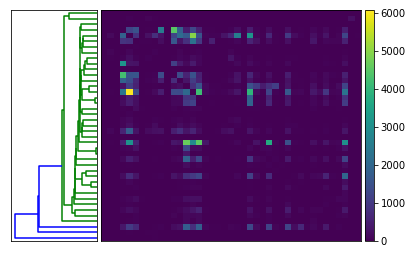

In [393]:
fig = figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
D = transition_matrix.as_matrix()
Y = linkage(D, method='single', metric='correlation')
Z = dendrogram(Y, orientation='left')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(mat, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
colorbar(im, cax=axcolor)

fig.show()

Index([u'Accademia', u'Brancacci', u'Cappelle Medicee', u'Casa Buonarroti',
       u'La Specola', u'Laurenziana', u'M. Antropologia', u'M. Archeologico',
       u'M. Bargello', u'M. Calcio', u'M. Casa Dante', u'M. Civici Fiesole',
       u'M. Ebraico', u'M. Ferragamo', u'M. Galileo', u'M. Geologia',
       u'M. Innocenti', u'M. Marini', u'M. Mineralogia', u'M. Novecento',
       u'M. Opificio', u'M. Palazzo Davanzati', u'M. Palazzo Vecchio',
       u'M. San Marco', u'M. Santa Maria Novella', u'M. Stefano Bardini',
       u'M. Stibbert', u'Opera del Duomo', u'Orto Botanico', u'Palazzo Medici',
       u'Palazzo Pitti', u'Palazzo Strozzi', u'Planetario', u'San Lorenzo',
       u'Santa Croce', u'Torre di Palazzo Vecchio', u'Uffizi', u'V. Bardini',
       u'M. Horne', u'M. Preistoria', u'Primo Conti'],
      dtype='object')

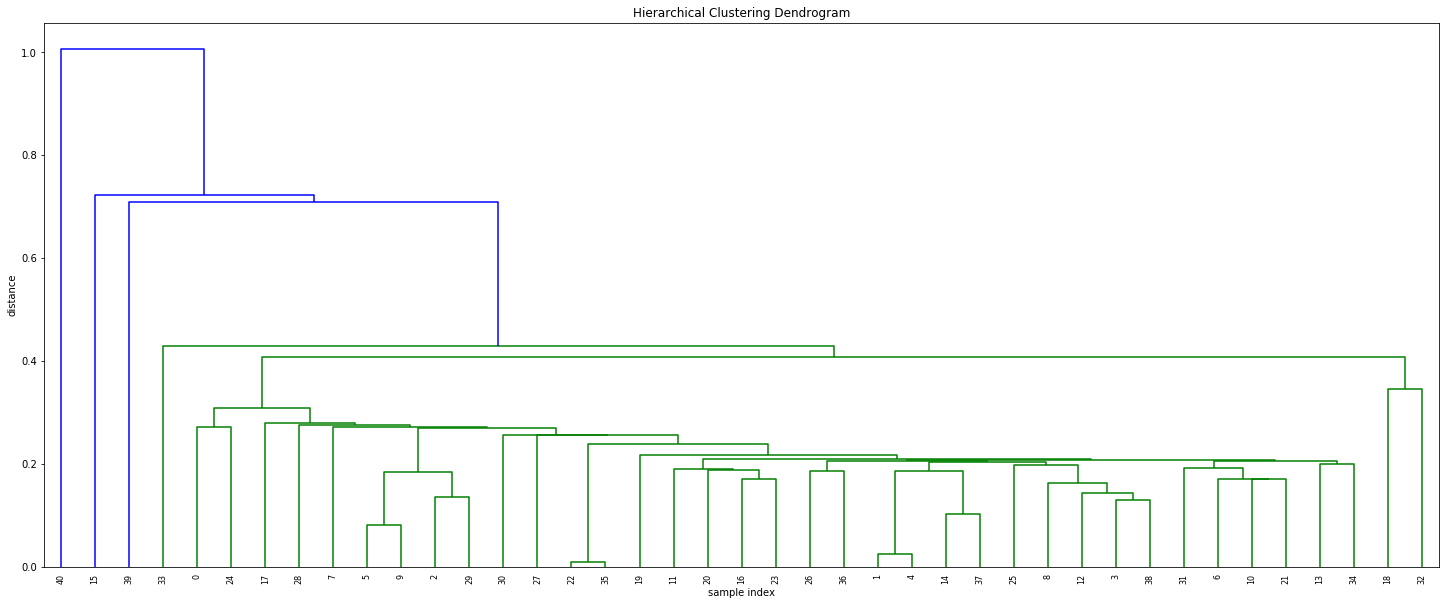

In [342]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

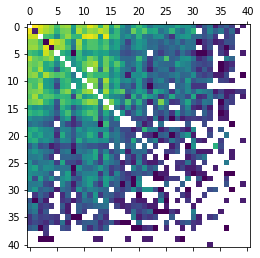

In [331]:
plt.matshow(np.log(mat))

In [332]:
mat = mat.div(mat.sum(axis=1), axis=0)

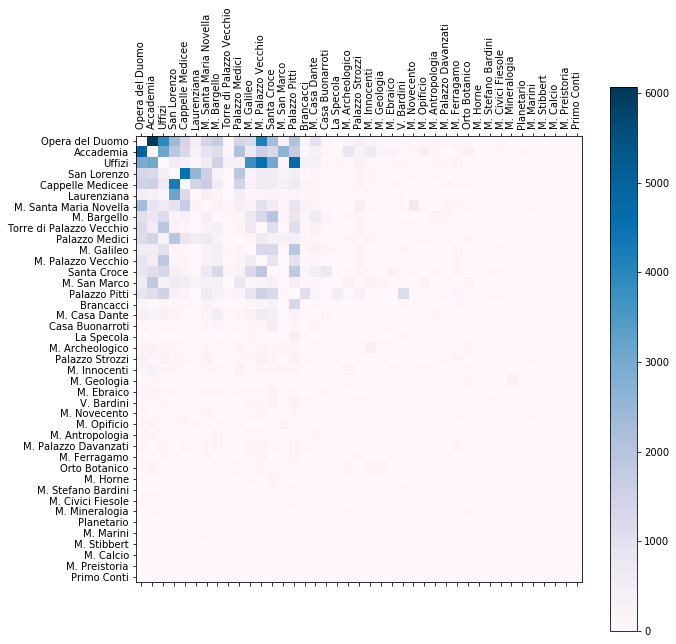

In [333]:
fig = plt.figure(figsize=(10,10))#,dpi=300)
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
# cax = ax.matshow(transition_matrix[order].reindex(order),cmap=cmap)
cax = ax.matshow(transition_matrix[order].reindex(order),cmap=cmap)
fig.colorbar(cax)

ax.set_xticklabels(['']+order.tolist(),rotation=90)
ax.set_yticklabels(['']+order.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

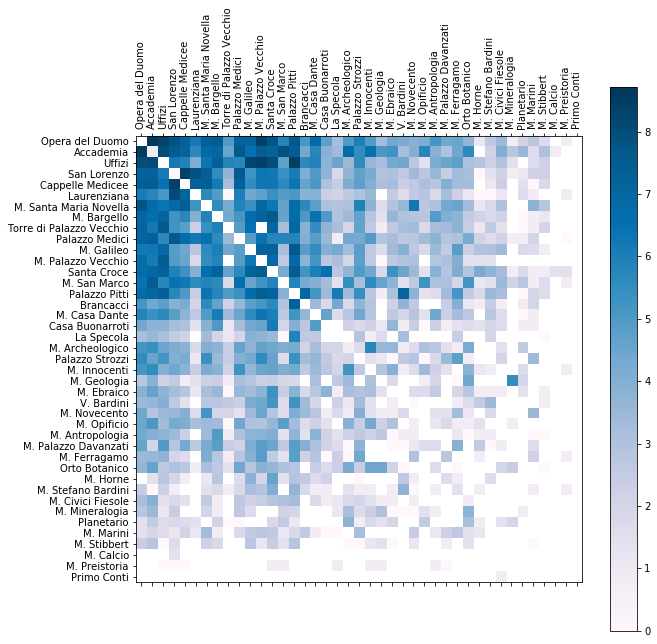

In [334]:
fig = plt.figure(figsize=(10,10))#,dpi=300)
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
# cax = ax.matshow(transition_matrix[order].reindex(order),cmap=cmap)
cax = ax.matshow(np.log(transition_matrix[order].reindex(order)),cmap=cmap)
fig.colorbar(cax)

ax.set_xticklabels(['']+order.tolist(),rotation=90)
ax.set_yticklabels(['']+order.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [51]:
mat2 = mat.drop(['M. Calcio', 'Primo Conti'])
mat2 = mat2.drop(['M. Calcio', 'Primo Conti'],axis=1)

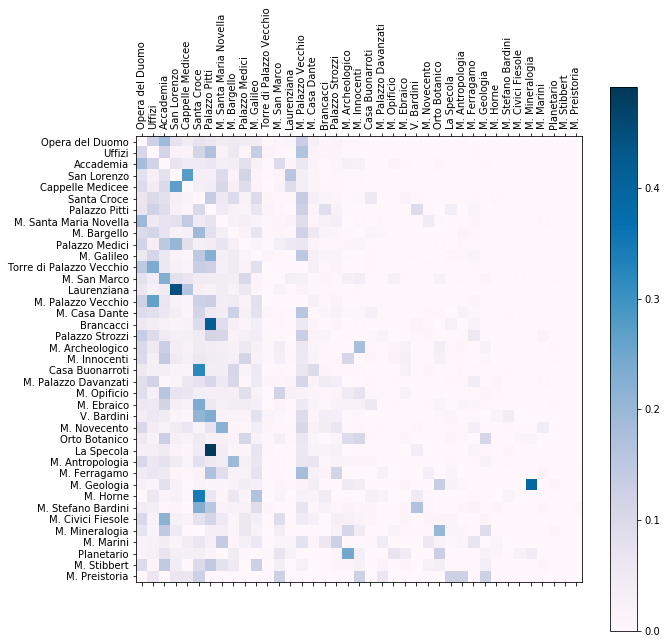

In [52]:
fig = plt.figure(figsize=(10,10))#,dpi=300)
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
# cax = ax.matshow(transition_matrix[order].reindex(order),cmap=cmap)
cax = ax.matshow(mat2,cmap=cmap)
fig.colorbar(cax)

ax.set_xticklabels(['']+mat2.index.tolist(),rotation=90)
ax.set_yticklabels(['']+mat2.index.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# Edgelist (to export?)

In [38]:
# Create the actual edgelist for the transition matrix (of a first-order Markov chain)
df5 = df4.groupby(['from','to'])['total_people'].sum().to_frame()
df5.columns = ['weight']
df5.reset_index(inplace=True)
df5.head(10)

from                to  weight
0  Accademia         Accademia       2
1  Accademia         Brancacci      77
2  Accademia  Cappelle Medicee    1277
3  Accademia   Casa Buonarroti      49
4  Accademia        La Specola      30
5  Accademia       Laurenziana     301
6  Accademia   M. Antropologia      51
7  Accademia   M. Archeologico     826
8  Accademia       M. Bargello    1022
9  Accademia         M. Calcio       2

In [39]:
# Export
df5.to_csv('static_edgelist.csv')
nodes[['short_name','longitude','latitude']].to_csv('node_positions.csv')